In [1]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import json

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:

# CatFLW 데이터셋 경로 설정
labels_dir = '/home/work/XAI/BITAmin/CatFLW/labels'
images_dir = '/home/work/XAI/BITAmin/CatFLW/images'


In [4]:

# Custom transforms
class Normalize(object):
    """Normalize the color range to [0,1] and convert a color image to grayscale if needed"""

    def __init__(self, color=False):
        self.color = color

    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]

        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        if not self.color:
            image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # scale color range from [0, 255] to [0, 1]
        image_copy = image_copy / 255.0

        # scale keypoints to be centered around 0 with a range of [-2, 2]
        key_pts_copy = (key_pts_copy - image.shape[0] / 2) / (image.shape[0] / 4)

        return {"image": image_copy, "keypoints": key_pts_copy}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))

        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {"image": img, "keypoints": key_pts}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]

        # if image has no grayscale color channel, add one
        if len(image.shape) == 2:
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {
            "image": torch.from_numpy(image),
            "keypoints": torch.from_numpy(key_pts),
        }


In [5]:
# CatKeypointsDataset 클래스 정의
class CatKeypointsDataset(Dataset):
    def __init__(self, labels_dir, images_dir, transform=None):
        self.labels_dir = labels_dir
        self.images_dir = images_dir
        self.data = self._load_data()
        self.transform = transform

    def _load_data(self):
        data = []
        for label_file in os.listdir(self.labels_dir):
            if label_file.endswith('.json'):
                with open(os.path.join(self.labels_dir, label_file), 'r') as file:
                    labels = json.load(file)
                    img_file = label_file.replace('.json', '.png')
                    data.append({'image': img_file, 'labels': labels['labels'], 'bounding_box': labels['bounding_boxes']})
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.data[idx]['image'])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR을 RGB로 변환
        keypoints = np.array(self.data[idx]['labels'])
        bounding_box = np.array(self.data[idx]['bounding_box'])
        sample = {'image': image, 'keypoints': keypoints, 'bounding_box': bounding_box}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
# 데이터셋 초기화
dataset = CatKeypointsDataset(
    labels_dir=labels_dir, 
    images_dir=images_dir,
    transform=None
)

# 데이터셋 크기 출력
print("Dataset size: ", len(dataset))


Dataset size:  2079


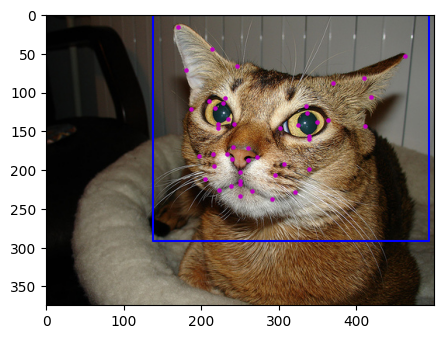

In [7]:
# 샘플 이미지와 키포인트를 시각화하는 함수
def show_keypoints(image, key_pts, bounding_box=None):
    """Show image with keypoints and bounding box"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker=".", c="m")
    if bounding_box is not None:
        plt.plot(
            [bounding_box[0], bounding_box[0], bounding_box[2], bounding_box[2], bounding_box[0]],
            [bounding_box[1], bounding_box[3], bounding_box[3], bounding_box[1], bounding_box[1]],
            c='blue'
        )

# 샘플 데이터 시각화
n = 2
sample = dataset[n]
image = sample['image']
keypoints = sample['keypoints']
bounding_box = sample['bounding_box']

plt.figure(figsize=(5, 5))
show_keypoints(image, keypoints, bounding_box)
plt.show()

0 (681, 1024, 3) (48, 2)
1 (333, 500, 3) (48, 2)
2 (500, 375, 3) (48, 2)


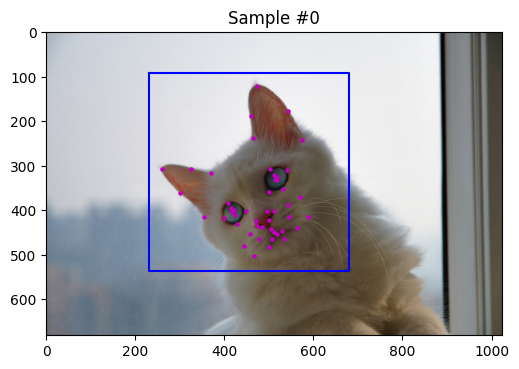

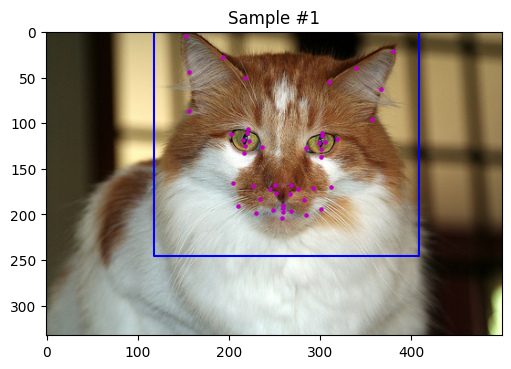

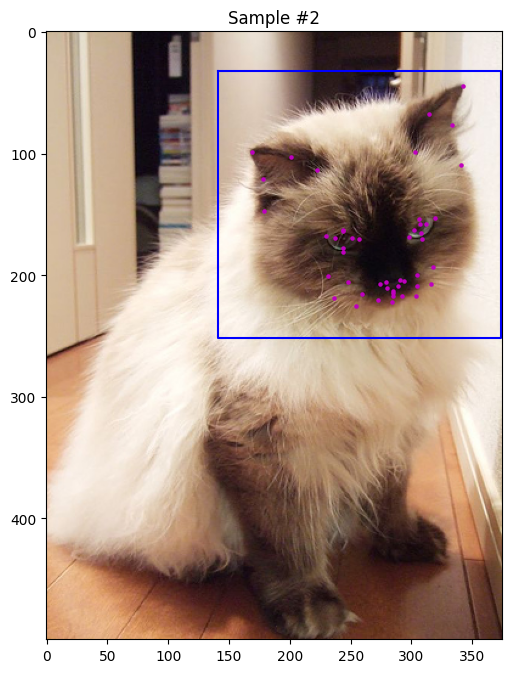

In [8]:
# 데이터셋에 있는 여러 이미지를 시각화
num_to_display = 3

for i in range(num_to_display):
    # define the size of images
    fig = plt.figure(figsize=(20, 10))

    # randomly select a sample
    rand_i = np.random.randint(0, len(dataset))
    sample = dataset[rand_i]  # call __getitem__

    # print the shape of the image and keypoints
    print(i, sample["image"].shape, sample["keypoints"].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title("Sample #{}".format(i))

    # Using the same display function, defined earlier
    show_keypoints(sample["image"], sample["keypoints"], sample["bounding_box"])

plt.show()

In [9]:
# 데이터 변환 정의
data_transform = transforms.Compose(
    [Rescale(250), Normalize(), ToTensor()]
)

# 변환된 데이터셋 생성
transformed_dataset = CatKeypointsDataset(
    labels_dir=labels_dir, 
    images_dir=images_dir,
    transform=data_transform
)

# 변환된 데이터셋 크기 출력
print("Number of images: ", len(transformed_dataset))

# 샘플 텐서 크기 확인
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample["image"].size(), sample["keypoints"].size())

Number of images:  2079
0 torch.Size([1, 250, 333]) torch.Size([48, 2])
1 torch.Size([1, 250, 304]) torch.Size([48, 2])
2 torch.Size([1, 250, 333]) torch.Size([48, 2])
3 torch.Size([1, 250, 375]) torch.Size([48, 2])
4 torch.Size([1, 250, 375]) torch.Size([48, 2])
